In [1]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [2]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets

In [11]:
# Issues with directories, use this to reset cwd and then move into desired directory 
#os.chdir("/content")
startingDir = os.getcwd()
print(startingDir)

C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2


In [29]:
""" Code to get max and min temperature values from dataset can 
be found using get_min_max_csvs.exe, from get_max_min.cpp.
Data from ~4000 csvs """
ABS_MAX = 40.0469
ABS_MIN = 22.0574

In [34]:
print(os.getcwd())
start = time.time()
#a = torch.randn(320,240)
#npa = np.genfromtxt('2015_03_03_02_35_bci_t.csv', delimiter = ',')
npa = pd.read_csv("2015_03_03_02_35_bci_t.csv")
npa = npa.values
npa = np.append(npa, [90])
a = torch.from_numpy(npa)
this = torch.min(a)
this = torch.max(a)
#2015_03_03_02_35_bci_t
print(a)
print("min is", this)
print(f'Time: {time.time()-start}')

temp = np.full(20000000,-10)
temp= np.append(temp,[10])
print(temp)


C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2
tensor([25.0321, 24.9651, 25.0321,  ..., 26.0778, 26.0370, 90.0000],
       dtype=torch.float64)
min is tensor(90., dtype=torch.float64)
Time: 0.038896799087524414
[-10 -10 -10 ... -10 -10  10]


In [48]:
""" CREATE CUSTOM DATASET """
# Pulls from pool of 900 thermal images
class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])        
        self.transform = transforms.ToTensor()
        max_list = np.full(1,-10)
        min_list = np.full(1, 99999)
        csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata4000"
        os.chdir(csvfilesMLLocation)
        start = time.time()
        for filename in self.thermal_path_arr:
            file_temps = pd.read_csv(filename)
            file_temps_vals = file_temps.values
            torch_temps = torch.from_numpy(file_temps_vals)
            max_list = np.append(max_list, [torch.max(torch_temps)])
            min_list = np.append(min_list, [torch.min(torch_temps)])
        self.ABS_MAX = (torch.max(torch.from_numpy(max_list))).item()
        self.ABS_MIN = (torch.min(torch.from_numpy(min_list))).item()
        print(f'Time: {time.time()-start}')
        print("max is:", self.ABS_MAX)
        print("max is:", self.ABS_MIN)
            
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Normalization of values from orignal csv file, translates thermal values to 0-1 range
        # https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
        np_normalized_temp_no_channel = ((np_thermal_img-self.ABS_MIN)/(self.ABS_MAX - self.ABS_MIN))
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Add num channels dimension and format correctly
        np_normalized_temp = np.expand_dims(np_normalized_temp_no_channel, axis=0)
        # Transform numpy array to tensor
        tensor_normal_thermal_vals = torch.from_numpy(np_normalized_temp)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        return(tensor_normal_thermal_vals, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [49]:
""" LOAD IN DATA """
os.chdir(startingDir)
# Number of subprocesses to use for data loading 
# Note: Currently unused but can be altered in future
num_workers = 0
# How many samples per batch to load
batch_size = 3
# Proportion of training set to use for validation and testing
# Note: this will be split in equal halves, one for validation, one for testing
valid_and_test_proportion = 0.3


# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])
# Define custom datasets, for training and for testing
# Note: Will be using 10,000 data for testing, 50,000 data for training in future
masterfileMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata4000/populatedGPPs.csv"
BCIDataset = BCIDataset2(masterfileMLLocation)

# Obtain indices for training, validation and testing datasets
num_train = len(BCIDataset)         # Number of data points (csv files to be used)
indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
np.random.shuffle(indices1)         # Shuffled indices
# Splitting training from validation/testing
split1 = int(np.floor(valid_and_test_proportion * num_train))

train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
# Splitting validation/testing up into their individual groups
num_valid_test = len(valid_and_test_indices)

split2 = int(np.floor(0.5 * num_valid_test))
valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]
# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Prepare data loaders 
train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers, pin_memory=True)

Time: 154.72337794303894
max is: 40.046902918943
max is: 22.0574247607658


torch.Size([3, 1, 320, 240])
tensor(0.)
tensor(0)
(1, 320, 240)
tensor(21.3105)
tensor(21)
(1, 320, 240)
tensor(0.)
tensor(0)
(1, 320, 240)


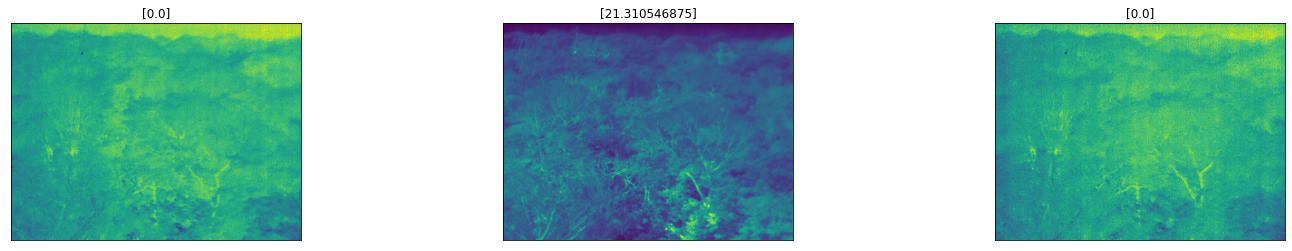

In [32]:
""" VISUALIZE A BATCH OF THE DATA 
    Taken straight from dataloader """
os.chdir(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata4000"
os.chdir(csvfilesMLLocation)

import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.rot90(np.squeeze(img)))
    
# Obtain one batch of training images
dataiter = iter(train_loader)
type(dataiter)
images, labels = dataiter.next()
print(images.shape)
images = images.numpy() # convert images to numpy for display
#print(images)

    # print(images[1].shape)
    # imgtoshow = Image.fromarray(images[1], 'L')
    # imgtoshow.show()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 3 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    print(labels[idx])
    print(labels[idx].long())
    ax.set_title([labels[idx].item()])
    # Save Images for inspection
    print(images[idx].shape)
os.chdir(startingDir)

In [33]:
"""Working network"""
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1, stride = 2)
        # Convulutional Layer 2 (sees 80 x 60 x 16 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear and Batchnorm Layers
        self.fc1 = nn.Linear(32 * 40 * 30, 100)
        self.BatchN = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 40 * 30)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add last layer
        x = (self.fc2(x))
        return x

In [34]:
# Defining the model
model = BCIModel()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr =0.001) 
# defining loss function
criterion = nn.MSELoss()
print(model)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...


In [35]:
# Optimization? Best for inputs that do not change in size (this network)
# "This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware"
torch.backends.cudnn.benchmark = True

# Check that we are on GPU
for p in model.parameters():
    print(p.device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    
"""
Test new pinned memory speeds
mess with number of workers"""

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


'\nTest new pinned memory speeds\nmess with number of workers'

In [36]:
""" TRAINING OF MODEL """


os.chdir(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata4000"
os.chdir(csvfilesMLLocation)
# Number of epochs to train the model
# try 10, 100, 500, 1000
n_epochs = 5

valid_loss_min = np.Inf    # Track change in validation loss, set 

for epoch in range(1, n_epochs+1):
    # Measurement of epoch times
    start = time.time()
    print("Epoch #:", epoch)
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # Clear the gradients fo all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # Calculate avearage losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_BCI.pt')
        valid_loss_min = valid_loss
    
    # End of time check
    print(f'Time: {time.time()-start}')
        
print("Operation Complete")

Epoch #: 1
Epoch: 1 	Training Loss: 31.529059 	Validation Loss: 19.867072
Validation loss decreased (inf --> 19.867072).  Saving model ...
Time: 100.17606687545776
Epoch #: 2
Epoch: 2 	Training Loss: 24.861636 	Validation Loss: 19.491581
Validation loss decreased (19.867072 --> 19.491581).  Saving model ...
Time: 106.71521401405334
Epoch #: 3
Epoch: 3 	Training Loss: 21.949192 	Validation Loss: 15.898426
Validation loss decreased (19.491581 --> 15.898426).  Saving model ...
Time: 97.2608892917633
Epoch #: 4
Epoch: 4 	Training Loss: 19.990159 	Validation Loss: 17.858829
Time: 95.73043966293335
Epoch #: 5
Epoch: 5 	Training Loss: 18.882055 	Validation Loss: 16.562908
Time: 95.76834201812744
Operation Complete


In [37]:
""" TESTING OF MODEL """

# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model.eval()

counter = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update test loss 
        test_loss += loss.item()*data.size(0)
        
        # Example data tensors
        if counter < 5:
          print("Output of network:\t", output)
          print("Target Values:\t\t", target,"\n")
          counter += 1
        


    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))

Output of network:	 tensor([ 1.5294, 15.4440, 18.2579], device='cuda:0')
Target Values:		 tensor([ 0.0000, 15.5176, 15.3181], device='cuda:0') 

Output of network:	 tensor([ 1.1218, 13.1476,  2.7972], device='cuda:0')
Target Values:		 tensor([ 0.0000, 11.7690, 10.4686], device='cuda:0') 

Output of network:	 tensor([1.4949, 1.5888, 1.6971], device='cuda:0')
Target Values:		 tensor([0., 0., 0.], device='cuda:0') 

Output of network:	 tensor([20.9226,  1.7254, 22.3628], device='cuda:0')
Target Values:		 tensor([19.0243,  8.1869, 21.4878], device='cuda:0') 

Output of network:	 tensor([16.2129, 12.9157,  1.7916], device='cuda:0')
Target Values:		 tensor([15.6937, 21.8395,  0.0000], device='cuda:0') 

Test Loss (mean squared error): 2.235293

